In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# download mnist_dataset to desired directory and split to train, val, test
from make_modular.configs import TRAIN_DATASET_PATH, TEST_DATASET_PATH
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = MNIST(TRAIN_DATASET_PATH, train=True, download=True, transform=transform)
test_ds = MNIST(TEST_DATASET_PATH, train=False, download=True, transform=transform)

# split train_dataset to train and validation dataset
val_percent = .15
val_size = int(val_percent * len(train_ds))
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [3]:
# test our datasets
len(train_ds), len(val_ds), len(test_ds)

(51000, 9000, 10000)

In [4]:
# make dataLoaders 
from make_modular.configs import batch_size

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [5]:
# test dataloaders
images, labels = next(iter(train_dl))

In [6]:
# convert image_tesnsor: (b, c, h, w) --> numpy_array: (b, h, w, c)=(b, 28, 28, 1)
# img = images.numpy().transpose(0, 2, 3, 1)
# plt.imshow(img[0])

In [7]:
# show some images of dataset
from make_modular.utils import show_images
# show_images(images, labels)

In [8]:
from make_modular.model import MNIST_MODEL_1
from make_modular.utils import print_train_time

# find best lr
from make_modular.utils import find_best_lr

start_time = time.time()

n_iter_lr_find = 3
lr_exp_list = find_best_lr(MNIST_MODEL_1, n_iter=n_iter_lr_find, train_dl=train_dl, val_dl=val_dl)
end_time = time.time()
total_time = print_train_time(start_time, end_time)

best_lr = min(lr_exp_list, key=lambda x: x[list(x.keys())[0]]['val_loss'][-1])
# print(f'best_lr : {best_lr}')

lrs = [] # key of dict:the lr
losses_correspond_lr = [] # the test_loss with correspond lr

for dictionary in lr_exp_list:
    min_test_loss_key = min(dictionary, key=lambda k: dictionary[k]['val_loss'][-1])
    lrs.append(min_test_loss_key)
    losses_correspond_lr.append(dictionary[min_test_loss_key]['val_loss'][-1])

lr : 2.490971578600081e-05
epoch 1/1 | train_loss:0.70 | val_loss:0.28 | train_f1_score:0.826 | val_f1_score:0.920
------------------------------------------------------------------------------------------------------------------------
lr : 4.421309379598148e-06
epoch 1/1 | train_loss:1.73 | val_loss:1.00 | train_f1_score:0.610 | val_f1_score:0.830
------------------------------------------------------------------------------------------------------------------------
lr : 0.0036832321268255573
epoch 1/1 | train_loss:0.17 | val_loss:0.07 | train_f1_score:0.948 | val_f1_score:0.981
------------------------------------------------------------------------------------------------------------------------

Train time: 4.312 minutes


In [9]:
lr_exp_list

[{2.490971578600081e-05: {'train_loss': [0.6989644092871075],
   'val_loss': [0.27805158913346895],
   'train_acc': [0.8274836440008587],
   'val_acc': [0.9212544327932046],
   'train_f1_score': [0.8264971499770901],
   'val_f1_score': [0.920372376171638]}},
 {4.421309379598148e-06: {'train_loss': [1.7275627730332475],
   'val_loss': [1.0010976580017847],
   'train_acc': [0.609159347553325],
   'val_acc': [0.8288120568221342],
   'train_f1_score': [0.6098391708939974],
   'val_f1_score': [0.8300960698448125]}},
 {0.0036832321268255573: {'train_loss': [0.16950377439227016],
   'val_loss': [0.06538264249643007],
   'train_acc': [0.9485934979493824],
   'val_acc': [0.9815381207364671],
   'train_f1_score': [0.9475438341705296],
   'val_f1_score': [0.9811926553668696]}}]

In [10]:
final_res_lr =  []

In [11]:
from make_modular.engine import train
from make_modular.configs import device

model = MNIST_MODEL_1()

lr = 5e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

start_time = time.time()
results = train(model=model,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                epochs=1)

final_res_lr.append({lr:results})

end_time = time.time()
total_time = print_train_time(start_time, end_time)

epoch 1/1 | train_loss:0.23 | val_loss:0.06 | train_f1_score:0.929 | val_f1_score:0.979

Train time: 1.389 minutes


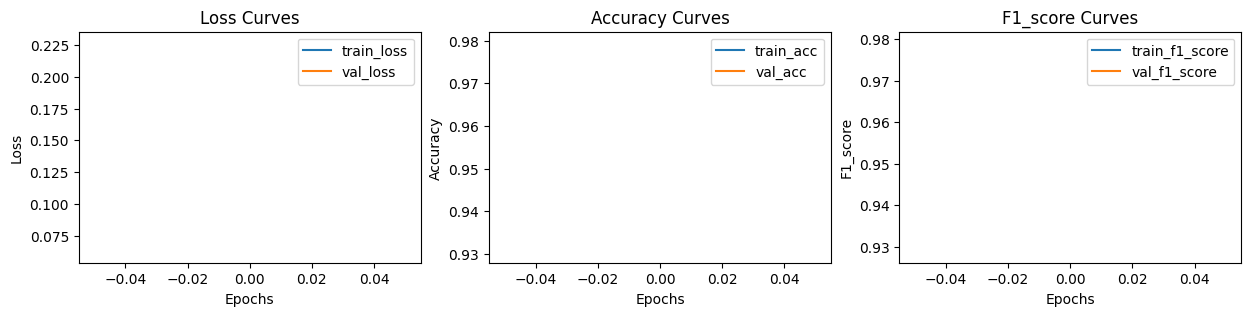

In [12]:
from make_modular.utils import plot_loss_curves
plot_loss_curves(results=results)

In [13]:
# save the model
root_model_path = './models/'
model_name = 'mn_model_1.pth'
# # model_name = 'model_2.pth'
# # model_name = 'model_3.pth'
# # model_name = 'model_4.pth'
# # model_name = 'model_5.pth'
# # model_name = 'model_6.pth'
model_path = root_model_path + model_name
torch.save(model.state_dict(), model_path)

In [14]:
# load the model
model = MNIST_MODEL_1()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [15]:
# test model on test set
from make_modular.engine import test_one_epoch
test_loss, test_acc, test_f1_score = test_one_epoch(model=model,
                                                    val_dl=test_dl,
                                                    loss_fn=loss_fn,
                                                    device=device)
test_loss, test_acc, test_f1_score

(0.04948953012743028, 0.9841759554140127, 0.9817392659722036)

In [16]:
# find best lr for models
# write function to dataloaders
# there is a problem with find best lr model should be inside the method 
# ask from gpt how to create new model in each for iterate